# Step 0: Explore the data

In [1]:
!pip install pandas
!pip install openpyxl
!pip install matplotlib
!pip install statsmodels
!pip install pmdarima

import requests
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pmdarima as pm


from datetime import datetime
from pyspark.sql import SparkSession
from pyspark.sql.functions import to_json,col
from pyspark.sql.types import *
from os.path import abspath
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from pmdarima.arima.utils import ndiffs


     |████████████████████████████████| 11.3 MB 1.9 MB/s eta 0:00:01    |██████████████▋                 | 5.2 MB 1.9 MB/s eta 0:00:04
     |████████████████████████████████| 15.7 MB 16.4 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
     |████████████████████████████████| 249 kB 1.4 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
     |████████████████████████████████| 11.2 MB 1.3 MB/s eta 0:00:01    |█████████▏                      | 3.2 MB 1.3 MB/s eta 0:00:07
     |████████████████████████████████| 965 kB 30.6 MB/s eta 0:00:01
     |████████████████████████████████| 1.1 MB 29.0 MB/s eta 0:00:01
     |████████████████████████████████| 3.4 MB 40.7 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
     |████████████████████████████████| 9.9 MB 2.9 MB/s eta 0:00:01     |██████▎                    

In [3]:
# Here we are going to make a hive connection with spark
spark = SparkSession\
        .builder\
        .appName("pyspark-notebook")\
        .master("spark://spark-master:7077")\
        .config("spark.executor.memory", "1g")\
        .config("hive.metastore.uris", "thrift://hive-metastore:9083")\
        .config("spark.sql.warehouse.dir", "/user/hive/warehouse")\
        .config("spark.sql.catalogImplementation", "hive")\
        .enableHiveSupport()\
        .getOrCreate()

spark.sparkContext.setLogLevel("ERROR")

23/05/19 07:55:50 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [3]:
df_spark_18_19_3076 = spark.sql("SELECT * FROM Balancesdb.balances WHERE COD_ENTIDAD = 3076")
df_spark_20_3076 = spark.sql("SELECT * FROM Balancesdb.balances20 WHERE COD_ENTIDAD = 3076")
df_spark_21_3076 = spark.sql("SELECT * FROM Balancesdb.balances21 WHERE COD_ENTIDAD = 3076")
df_spark_22_3076 = spark.sql("SELECT * FROM Balancesdb.balances22 WHERE COD_ENTIDAD = 3076")


<class 'pandas.core.frame.DataFrame'>
Int64Index: 20 entries, 645 to 210
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   FECHA   20 non-null     object 
 1   VALOR   20 non-null     float64
dtypes: float64(1), object(1)
memory usage: 480.0+ bytes


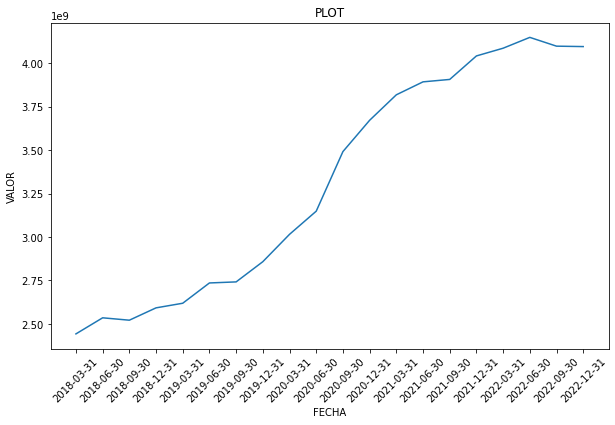

In [48]:
#Convert the spark dataframe into pandas dataframe
df_pandas_18_19_3076 = df_spark_18_19_3076.toPandas()
df_pandas_20_3076 = df_spark_20_3076.toPandas()
df_pandas_21_3076 = df_spark_21_3076.toPandas()
df_pandas_22_3076 = df_spark_22_3076.toPandas()

#Select the columns that we will use
df_pandas_18_19_3076 = df_pandas_18_19_3076.loc[:, ['FECHA', 'VALOR', 'EPIGRAFE']]
df_pandas_20_3076 = df_pandas_20_3076.loc[:, ['FECHA', 'VALOR', 'EPIGRAFE']]
df_pandas_21_3076 = df_pandas_21_3076.loc[:, ['FECHA', 'VALOR', 'EPIGRAFE']]
df_pandas_22_3076 = df_pandas_22_3076.loc[:, ['FECHA', 'VALOR', 'EPIGRAFE']]

#We choose the value of the epigrafe
df_pandas_18_19_3076 = df_pandas_18_19_3076[df_pandas_18_19_3076['EPIGRAFE'] == 'TOTAL ACTIVO']
df_pandas_20_3076 = df_pandas_20_3076[df_pandas_20_3076['EPIGRAFE'] == 'TOTAL ACTIVO']
df_pandas_21_3076 = df_pandas_21_3076[df_pandas_21_3076['EPIGRAFE'] == 'TOTAL ACTIVO']
df_pandas_22_3076 = df_pandas_22_3076[df_pandas_22_3076['EPIGRAFE'] == 'TOTAL ACTIVO']

#sort the data
df_18_19_sorted = df_pandas_18_19_3076.sort_values('FECHA')
df_20_sorted = df_pandas_20_3076.sort_values('FECHA')
df_21_sorted = df_pandas_21_3076.sort_values('FECHA')
df_22_sorted = df_pandas_22_3076.sort_values('FECHA')

df_3076 = pd.concat([df_18_19_sorted, df_20_sorted, df_21_sorted, df_22_sorted], axis=0)
df_3076 = df_3076.drop('EPIGRAFE', axis=1)

df_3076.info()

# chart
plt.figure(figsize=(10, 6)) 
plt.plot(df_3076['FECHA'], df_3076['VALOR'])
plt.xlabel('FECHA')
plt.ylabel('VALOR')
plt.title('PLOT')
plt.xticks(rotation=45)
plt.show()

# Step 1: Check for stationarity of time series

In [49]:
adf_test = adfuller(df_3076['VALOR'])
print(f'p-value: {adf_test[1]}')

p-value: 0.9970221884394525


##  ACF plot and PACF plot

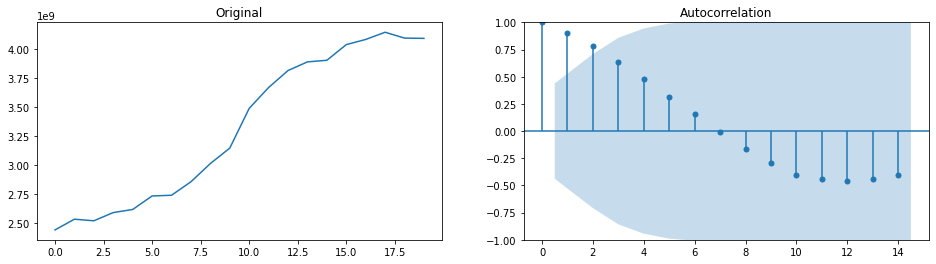

In [50]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize= (16, 4))

df_3076.reset_index(drop=True, inplace=True)
df = df_3076.copy()
ax1.plot(df.VALOR)
ax1.set_title("Original")
plot_acf(df.VALOR, ax=ax2);


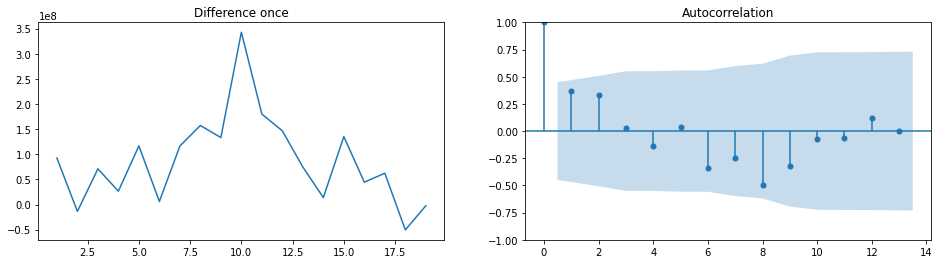

In [51]:
diff = df.VALOR.diff().dropna()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize= (16, 4))

ax1.plot(diff)
ax1.set_title('Difference once')
plot_acf(diff, ax=ax2);

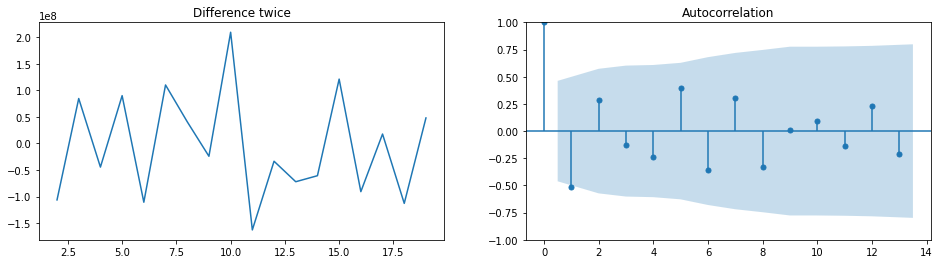

In [52]:
diff = df.VALOR.diff().diff().dropna()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize= (16, 4))

ax1.plot(diff)
ax1.set_title('Difference twice')
plot_acf(diff, ax=ax2);

In [53]:
ndiffs(df.VALOR, test='adf')

2

# Step 2: Determine ARIMA models parameters p, q

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


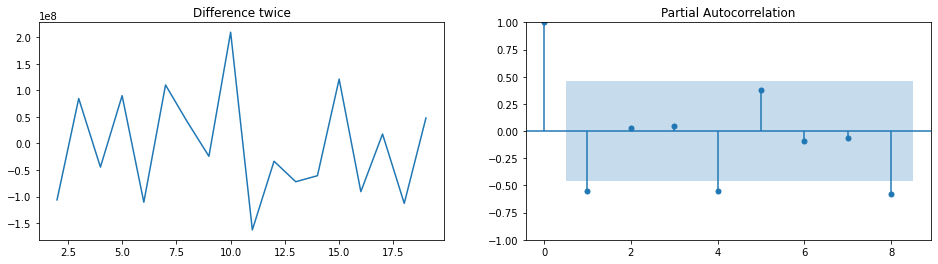

In [54]:
diff = df.VALOR.diff().diff().dropna()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize= (16, 4))

ax1.plot(diff)
ax1.set_title('Difference twice')
ax2.set_ylim(0,1)
plot_pacf(diff, ax=ax2, lags = 8);

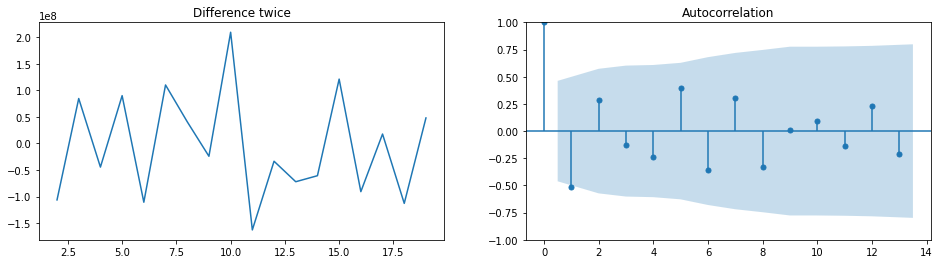

In [55]:
diff = df.VALOR.diff().diff().dropna()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize= (16, 4))

ax1.plot(diff)
ax1.set_title('Difference twice')
ax2.set_ylim(0,1)
plot_acf(diff, ax=ax2);

In [56]:
#ARIMA MODEL

model = ARIMA(df.VALOR, order=(4,2,1))
result = model.fit()
print(result.summary())

                               SARIMAX Results                                
Dep. Variable:                  VALOR   No. Observations:                   20
Model:                 ARIMA(4, 2, 1)   Log Likelihood                -354.081
Date:                Tue, 16 May 2023   AIC                            720.162
Time:                        19:19:51   BIC                            725.504
Sample:                             0   HQIC                           720.898
                                 - 20                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5386      0.406     -1.327      0.185      -1.334       0.257
ar.L2         -0.0879      0.215     -0.410      0.682      -0.508       0.333
ar.L3         -0.0625      0.163     -0.384      0.7

(array([1.06013606e-10, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        1.69621769e-09, 2.12027212e-10, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 1.06013606e-10]),
 array([-2.27375599e+09, -1.80211841e+09, -1.33048084e+09, -8.58843262e+08,
        -3.87205687e+08,  8.44318888e+07,  5.56069464e+08,  1.02770704e+09,
         1.49934462e+09,  1.97098219e+09,  2.44261977e+09]),
 <BarContainer object of 10 artists>)

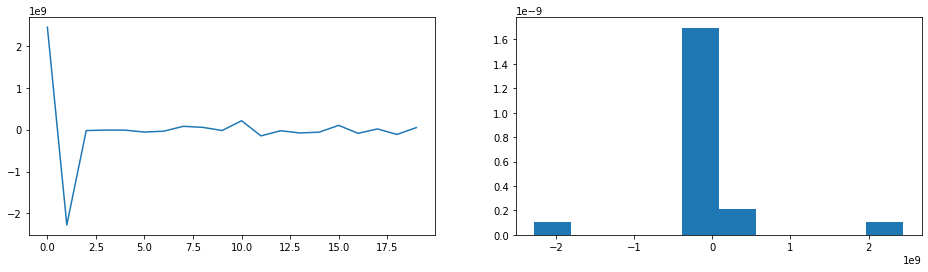

In [57]:
#Plot residual errors

residuals = pd.DataFrame(result.resid)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize= (16, 4))

ax1.plot(residuals)
ax2.hist(residuals, density=True)

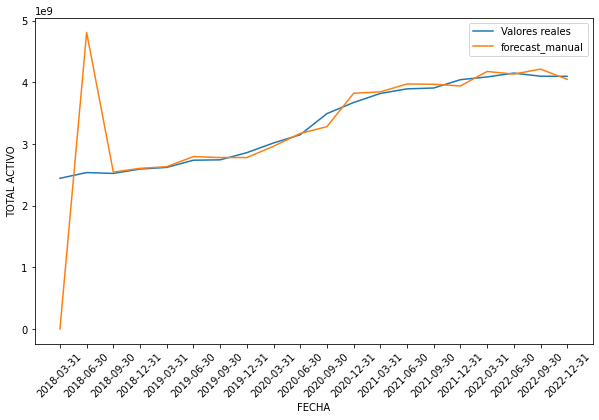

In [58]:
#Actual vs Fitted

# Realizar predicciones para todos los datos
forecast = result.predict(start=0, end=len(df) - 1)
df_testing1 = df.copy()
# Agregar las predicciones al DataFrame
df_testing1['forecast'] = forecast

# Graficar los valores reales y predichos
plt.figure(figsize=(10, 6)) 
plt.plot(df_testing1.FECHA, df_testing1['VALOR'], label='Valores reales')
plt.plot(df_testing1.FECHA, df_testing1['forecast'], label='forecast_manual')
plt.xlabel('FECHA')
plt.ylabel('TOTAL ACTIVO')
plt.xticks(rotation=45)
plt.legend()
plt.show()

# Optional: Auto-fit the ARIMA model

In [59]:

# encontrar los valores óptimos de p, d y q

model = pm.auto_arima(df['VALOR'], start_p=1, start_q=1,
                      test='adf',       # prueba de estacionariedad usando el test ADF
                      max_p=5, max_q=5,  # valores máximos de p y q ajustados a 2
                      m=1,              # frecuencia de la serie de tiempo (1 para series de tiempo no estacionales)
                      d=None,           # dejar que auto_arima determine el valor óptimo de d
                      seasonal=False,   # serie de tiempo no estacional
                      start_P=0,
                      D=0,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)


Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=718.576, Time=0.09 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=717.559, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=720.221, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=719.223, Time=0.02 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=715.714, Time=0.02 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0]          
Total fit time: 0.232 seconds


In [60]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   20
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -356.857
Date:                Tue, 16 May 2023   AIC                            715.714
Time:                        19:20:21   BIC                            716.605
Sample:                             0   HQIC                           715.837
                                 - 20                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      8.697e+15   3.37e+15      2.578      0.010    2.08e+15    1.53e+16
===================================================================================
Ljung-Box (L1) (Q):                   5.70   Jarque-Bera (JB):                 0.88
Prob(Q):                              0.02   Prob(JB):                         0.64
Heteroskedasticity (H):               0.79   Skew:                             0.40
Prob(H) (two-sided):                  0.79   Kurtosis:                         2.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

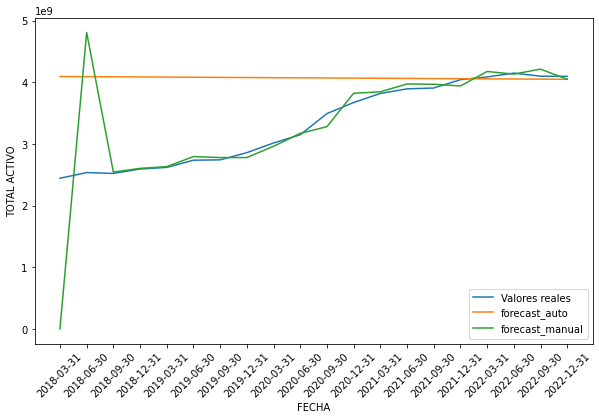

In [61]:
# Realizar predicciones para todos los datos
forecast_aut = model.predict(n_periods=len(df))

forecast_aut.reset_index(drop=True, inplace=True)
# Agregar las predicciones al DataFrame
df_testing2 = df.copy()
df_testing2['forecast_auto'] = forecast_aut

# Graficar los valores reales y predichos
plt.figure(figsize=(10, 6)) 
plt.plot(df_testing2.FECHA, df_testing2['VALOR'], label='Valores reales')
plt.plot(df_testing2.FECHA, df_testing2['forecast_auto'], label='forecast_auto')
plt.plot(df_testing1.FECHA, df_testing1['forecast'], label='forecast_manual')
plt.xlabel('FECHA')
plt.ylabel('TOTAL ACTIVO')
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [62]:
mae = mean_absolute_error(df.VALOR, forecast)
mape = mean_absolute_percentage_error(df.VALOR, forecast)
rmse = np.sqrt(mean_squared_error(df.VALOR, forecast))

print(f'mae - manual: {mae}')
print(f'mape - manual: {mape}')
print(f'rmse - manual: {rmse}')

mae - manual: 295488821.48553926
mape - manual: 0.11184185891828294
rmse - manual: 750450168.2275323


In [63]:
mae = mean_absolute_error(df.VALOR, forecast_aut)
mape = mean_absolute_percentage_error(df.VALOR, forecast_aut)
rmse = np.sqrt(mean_squared_error(df.VALOR, forecast_aut))

print(f'mae - auto: {mae}')
print(f'mape - auto: {mape}')
print(f'rmse - auto: {rmse}')

mae - auto: 769838697.7965
mape - auto: 0.27877008687689575
rmse - auto: 991326575.7454274


# Training and test sets

In [64]:
df_aux = df[['FECHA', 'VALOR']].copy()
df_aux.describe()

,VALOR
count,2.000000e+01
mean,3.323091e+09
std,6.541832e+08
min,2.442620e+09
25%,2.706506e+09
50%,3.320129e+09
75%,3.940485e+09
max,4.148635e+09


In [65]:
#Train test split
n = int(len(df_aux) * 0.8)
df_train = df_aux.VALOR[:n]
df_test = df_aux.VALOR[n:]


In [66]:
model = ARIMA(df_train, order=(4,2,1))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  VALOR   No. Observations:                   16
Model:                 ARIMA(4, 2, 1)   Log Likelihood                -275.864
Date:                Tue, 16 May 2023   AIC                            563.727
Time:                        19:21:03   BIC                            567.562
Sample:                             0   HQIC                           563.372
                                 - 16                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5207      0.405     -1.286      0.198      -1.314       0.273
ar.L2         -0.0819      0.211     -0.388      0.698      -0.496       0.332
ar.L3         -0.0576      0.185     -0.311      0.7

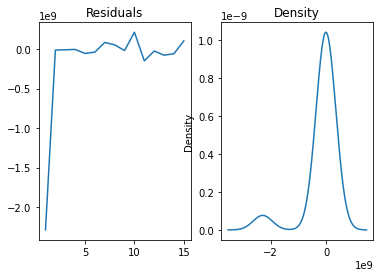

In [67]:
residuals = model_fit.resid[1:]
fig, ax = plt.subplots(1,2)
residuals.plot(title='Residuals', ax=ax[0])
residuals.plot(title='Density', kind='kde', ax=ax[1])
plt.show()

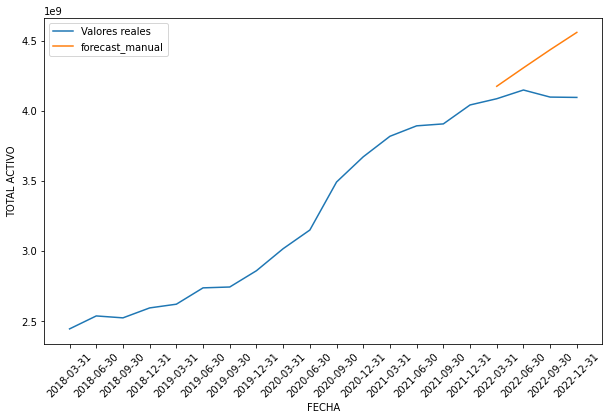

In [68]:
forecast_test = model_fit.forecast(len(df_test))

df_aux['forecast_manual'] = [None]*len(df_train) + list(forecast_test)

# Graficar los valores reales y predichos
plt.figure(figsize=(10, 6)) 
plt.plot(df_aux.FECHA, df_aux['VALOR'], label='Valores reales')
plt.plot(df_aux.FECHA, df_aux['forecast_manual'], label='forecast_manual')
plt.xlabel('FECHA')
plt.ylabel('TOTAL ACTIVO')
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [69]:
auto_arima = pm.auto_arima(df_train, stepwise=False, seasonal=False, error_action="ignore")
auto_arima

ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True)

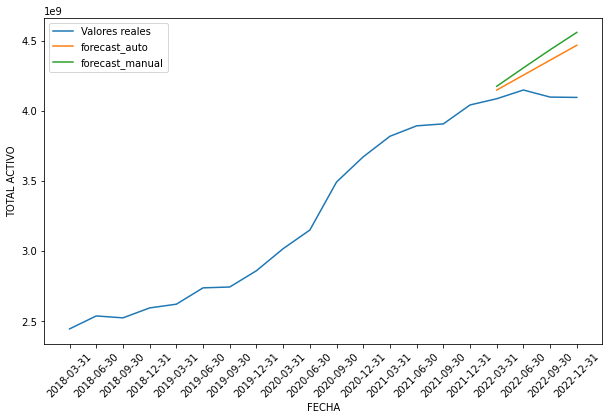

In [70]:
forecast_test_auto = auto_arima.predict(n_periods=len(df_test))
df_aux['forecast_auto'] = [None]*len(df_train) + list(forecast_test_auto)

# Graficar los valores reales y predichos
plt.figure(figsize=(10, 6)) 
plt.plot(df_aux.FECHA, df_aux['VALOR'], label='Valores reales')
plt.plot(df_aux.FECHA, df_aux['forecast_auto'], label='forecast_auto')
plt.plot(df_aux.FECHA, df_aux['forecast_manual'], label='forecast_manual')
plt.xlabel('FECHA')
plt.ylabel('TOTAL ACTIVO')
plt.xticks(rotation=45)
plt.legend()
plt.show()

# Evaluate model predictions

In [71]:
mae = mean_absolute_error(df_test, forecast_test)
mape = mean_absolute_percentage_error(df_test, forecast_test)
rmse = np.sqrt(mean_squared_error(df_test, forecast_test))

print(f'mae - manual: {mae}')
print(f'mape - manual: {mape}')
print(f'rmse - manual: {rmse}')

mae - manual: 262440882.86322594
mape - manual: 0.06395386062312519
rmse - manual: 301236501.3777132


In [72]:
mae = mean_absolute_error(df_test, forecast_test_auto)
mape = mean_absolute_percentage_error(df_test, forecast_test_auto)
rmse = np.sqrt(mean_squared_error(df_test, forecast_test_auto))

print(f'mae - auto: {mae}')
print(f'mape - auto: {mape}') 
print(f'rmse - auto: {rmse}')

mae - auto: 201214483.2933334
mape - auto: 0.0490443272908284
rmse - auto: 236396853.65874314


# 2023 predictions

In [73]:
#Now we are going to predict 4 values more for (2023-03-31, 2023-06-30, 2023-09-30, 2023-12-31)

forecast_test = model_fit.forecast(8)

forecast_test_auto = auto_arima.predict(n_periods=8)


In [74]:
# Crear una lista de fechas trimestrales desde 2022-03-31 hasta 2023-12-31 (forecast manual)
fechas = pd.date_range(start='2022-03-31', end='2023-12-31', freq='3M')
# Crear el DataFrame
df_2023 = pd.DataFrame({'Fechas': fechas, 'Valores': forecast_test})


In [75]:
# (forecast auto)
# Crear el DataFrame
df_2023_auto = pd.DataFrame({'Fechas': fechas, 'Valores': forecast_test_auto})


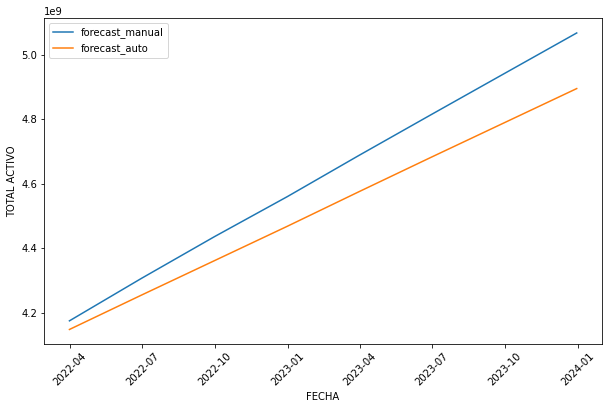

In [76]:
# Graficar los valores reales y predichos
plt.figure(figsize=(10, 6)) 
plt.plot(df_2023.Fechas, df_2023['Valores'], label='forecast_manual')
plt.plot(df_2023_auto.Fechas, df_2023_auto['Valores'], label='forecast_auto')
plt.xlabel('FECHA')
plt.ylabel('TOTAL ACTIVO')
plt.xticks(rotation=45)
plt.legend()
plt.show()